In [1]:
import pandas as pd
from rdkit import Chem,DataStructs
from rdkit.Chem import AllChem,PandasTools
import rdkit
import numpy as np
import matplotlib.pyplot as plt
import catboost as cat
from sklearn.model_selection import cross_val_score

In [2]:
df=pd.read_csv(r"C:\Users\19189\Desktop\original_data.csv")
df.head(2)

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50
0,68523-18-2,460.0,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758
1,88-04-0,3830.0,CC1C=C(O)C=C(C)C=1Cl,3.583199


In [3]:
def MACCSfp(mol):
    fp = rdkit.Chem.rdMolDescriptors.GetMACCSKeysFingerprint(mol)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

In [4]:
PandasTools.AddMoleculeColumnToFrame(df,'Canonical_QSARr','Molecule')
df.head(2)

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50,Molecule
0,68523-18-2,460.0,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758,<rdkit.Chem.rdchem.Mol object at 0x000001FC3CE...
1,88-04-0,3830.0,CC1C=C(O)C=C(C)C=1Cl,3.583199,<rdkit.Chem.rdchem.Mol object at 0x000001FC3CE...


In [5]:
df["MACCSFPs"] =df.Molecule.apply(MACCSfp)
df.head(2)

,CASRN,CATMoS_LD50_mgkg,Canonical_QSARr,LogLD50,Molecule,MACCSFPs
0,68523-18-2,460.0,CC1(C)C(C1C=C(Cl)Cl)C(=O)OC(C#N)C1C=CC=C(N=1)O...,2.662758,<rdkit.Chem.rdchem.Mol object at 0x000001FC3CE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,88-04-0,3830.0,CC1C=C(O)C=C(C)C=1Cl,3.583199,<rdkit.Chem.rdchem.Mol object at 0x000001FC3CE...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
fp_df = df["MACCSFPs"].apply(pd.Series)
fp_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,1,1,1,0


In [7]:
x = fp_df.iloc[:,0:167]
y = df['LogLD50'].values

In [15]:
import optuna

def objective(trial):
    param = {
        'iterations':trial.suggest_int("iterations", 500, 1000, step=100),
        'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1.0, log=True),
        'depth':trial.suggest_int("depth", 4, 10, step=1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 1.0, log=True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]), 
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]), 
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20), 
        'random_strength':trial.suggest_float("random_strength", 1e-8, 5.0, log=True),
        'leaf_estimation_method':trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
    }
    if param["bootstrap_type"] == "Bayesian": 
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10) 
    elif param["bootstrap_type"] == "Bernoulli": 
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1) 
    
    cat_model = cat.CatBoostRegressor(**param)

    r2 = cross_val_score(cat_model, x, y, n_jobs=-1, cv=5, scoring="r2").mean()
    
    return r2

study = optuna.create_study(
    direction="maximize",
    study_name="catboost_parameter_opt",
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

study.optimize(objective, n_trials=100)
df = study.trials_dataframe()
df.to_csv(r'C:\Users\19189\Desktop\MACCS_cat_trial1.csv',index=False)

[I 2024-04-07 21:24:34,487] A new study created in memory with name: catboost_parameter_opt
[I 2024-04-07 21:24:39,503] Trial 0 finished with value: 0.383072694318912 and parameters: {'iterations': 600, 'learning_rate': 0.013722688562229112, 'depth': 6, 'l2_leaf_reg': 1.9881770051956487e-05, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 17, 'random_strength': 5.6431744655640456e-05, 'leaf_estimation_method': 'Newton'}. Best is trial 0 with value: 0.383072694318912.
[I 2024-04-07 21:25:20,681] Trial 1 finished with value: 0.47190003833700295 and parameters: {'iterations': 700, 'learning_rate': 0.3267101504634497, 'depth': 7, 'l2_leaf_reg': 0.3589896846056661, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 19, 'random_strength': 4.917804462534541e-05, 'leaf_estimation_method': 'Gradient'}. Best is trial 1 with value: 0.47190003833700295.
[I 2024-04-07 21:25:28,887] Trial 2 finished with value: 0.2366761928549118 and parameters: {'iterati

In [ ]:
iterations=None,
                        learning_rate=None,
                        depth=None,
                        l2_leaf_reg=None,
                        model_size_reg=None,
                        rsm=None,
                        loss_function='RMSE',
                        border_count=None,
                        feature_border_type=None,
                        per_float_feature_quantization=None,
                        input_borders=None,
                        output_borders=None,
                        fold_permutation_block=None,
                        od_pval=None,
                        od_wait=None,
                        od_type=None,
                        nan_mode=None,
                        counter_calc_method=None,
                        leaf_estimation_iterations=None,
                        leaf_estimation_method=None,
                        thread_count=None,
                        random_seed=None,
                        use_best_model=None,
                        best_model_min_trees=None,
                        verbose=None,
                        silent=None,
                        logging_level=None,
                        metric_period=None,
                        ctr_leaf_count_limit=None,
                        store_all_simple_ctr=None,
                        max_ctr_complexity=None,
                        has_time=None,
                        allow_const_label=None,
                        one_hot_max_size=None,
                        random_strength=None,
                        name=None,
                        ignored_features=None,
                        train_dir=None,
                        custom_metric=None,
                        eval_metric=None,
                        bagging_temperature=None,
                        save_snapshot=None,
                        snapshot_file=None,
                        snapshot_interval=None,
                        fold_len_multiplier=None,
                        used_ram_limit=None,
                        gpu_ram_part=None,
                        pinned_memory_size=None,
                        allow_writing_files=None,
                        final_ctr_computation_mode=None,
                        approx_on_full_history=None,
                        boosting_type=None,
                        simple_ctr=None,
                        combinations_ctr=None,
                        per_feature_ctr=None,
                        ctr_target_border_count=None,
                        task_type=None,
                        device_config=None,
                        devices=None,
                        bootstrap_type=None,
                        subsample=None,
                        sampling_unit=None,
                        dev_score_calc_obj_block_size=None,
                        max_depth=None,
                        n_estimators=None,
                        num_boost_round=None,
                        num_trees=None,
                        colsample_bylevel=None,
                        random_state=None,
                        reg_lambda=None,
                        objective=None,
                        eta=None,
                        max_bin=None,
                        gpu_cat_features_storage=None,
                        data_partition=None,
                        metadata=None,
                        early_stopping_rounds=None,
                        cat_features=None,
                        grow_policy=None,
                        min_data_in_leaf=None,
                        min_child_samples=None,
                        max_leaves=None,
                        num_leaves=None,
                        score_function=None,
                        leaf_estimation_backtracking=None,
                        ctr_history_unit=None,
                        monotone_constraints=None,
                        feature_weights=None,
                        penalties_coefficient=None,
                        first_feature_use_penalties=None,
                        model_shrink_rate=None,
                        model_shrink_mode=None,
                        langevin=None,
                        diffusion_temperature=None,
                        posterior_sampling=None,
                        boost_from_average=None,
                        fixed_binary_splits=None)

In [16]:
df1=pd.read_csv(r'C:\Users\19189\Desktop\MACCS_cat_trial1.csv')
df1

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_depth,params_iterations,params_l2_leaf_reg,params_leaf_estimation_method,params_learning_rate,params_min_data_in_leaf,params_random_strength,params_subsample,state
0,0,0.383073,2024-04-07 21:24:34.487047,2024-04-07 21:24:39.503552,0 days 00:00:05.016505,NaN,Plain,MVS,6,600,1.988177e-05,Newton,0.013723,17,0.000056,NaN,COMPLETE
1,1,0.471900,2024-04-07 21:24:39.504639,2024-04-07 21:25:20.680675,0 days 00:00:41.176036,NaN,Ordered,MVS,7,700,3.589897e-01,Gradient,0.326710,19,0.000049,NaN,COMPLETE
2,2,0.236676,2024-04-07 21:25:20.681690,2024-04-07 21:25:28.886721,0 days 00:00:08.205031,9.781690,Plain,Bayesian,7,700,1.314264e-08,Newton,0.004022,11,0.000057,NaN,COMPLETE
3,3,0.422057,2024-04-07 21:25:28.887723,2024-04-07 21:26:21.658885,0 days 00:00:52.771162,8.546208,Ordered,Bayesian,8,500,4.424570e-08,Newton,0.381776,10,0.047499,NaN,COMPLETE
4,4,0.506563,2024-04-07 21:26:21.659889,2024-04-07 21:28:04.851180,0 days 00:01:43.191291,NaN,Ordered,Bernoulli,9,500,3.778450e-08,Gradient,0.074751,9,0.174550,0.901345,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.538510,2024-04-07 23:39:14.393135,2024-04-07 23:39:48.814961,0 days 00:00:34.421826,NaN,Plain,MVS,9,900,2.552212e-02,Gradient,0.074363,12,0.000010,NaN,COMPLETE
96,96,0.538923,2024-04-07 23:39:48.815976,2024-04-07 23:40:23.456591,0 days 00:00:34.640615,NaN,Plain,MVS,9,900,2.022888e-02,Gradient,0.065187,12,0.000010,NaN,COMPLETE
97,97,0.537374,2024-04-07 23:40:23.457607,2024-04-07 23:40:57.879499,0 days 00:00:34.421892,NaN,Plain,MVS,9,900,2.289961e-02,Gradient,0.075052,12,0.000011,NaN,COMPLETE
98,98,0.535114,2024-04-07 23:40:57.880502,2024-04-07 23:41:32.760514,0 days 00:00:34.880012,1.734476,Plain,Bayesian,9,900,2.054776e-02,Gradient,0.065617,12,0.000011,NaN,COMPLETE


In [17]:
df_sort=df1.sort_values(by='value',ascending=False)
df_sort

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_depth,params_iterations,params_l2_leaf_reg,params_leaf_estimation_method,params_learning_rate,params_min_data_in_leaf,params_random_strength,params_subsample,state
93,93,0.540493,2024-04-07 23:38:12.834085,2024-04-07 23:38:43.638025,0 days 00:00:30.803940,NaN,Plain,MVS,9,800,2.121786e-02,Gradient,0.068938,9,2.456175e-06,NaN,COMPLETE
96,96,0.538923,2024-04-07 23:39:48.815976,2024-04-07 23:40:23.456591,0 days 00:00:34.640615,NaN,Plain,MVS,9,900,2.022888e-02,Gradient,0.065187,12,1.018275e-05,NaN,COMPLETE
87,87,0.538837,2024-04-07 23:36:22.537153,2024-04-07 23:36:41.712671,0 days 00:00:19.175518,NaN,Plain,MVS,8,900,2.110804e-03,Gradient,0.052672,8,4.868580e-06,NaN,COMPLETE
99,99,0.538786,2024-04-07 23:41:32.760514,2024-04-07 23:42:07.165369,0 days 00:00:34.404855,NaN,Plain,MVS,9,900,5.692883e-02,Gradient,0.068657,11,2.231953e-05,NaN,COMPLETE
41,41,0.538687,2024-04-07 23:24:00.397449,2024-04-07 23:24:30.909533,0 days 00:00:30.512084,NaN,Plain,MVS,9,800,3.371719e-02,Gradient,0.075909,14,4.050480e+00,NaN,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,10,0.059074,2024-04-07 21:29:06.973474,2024-04-07 21:37:00.998665,0 days 00:07:54.025191,NaN,Ordered,Bernoulli,10,1000,2.064057e-05,Gradient,0.000433,3,3.075559e+00,0.957304,COMPLETE
9,9,0.004777,2024-04-07 21:29:01.729322,2024-04-07 21:29:06.971474,0 days 00:00:05.242152,NaN,Plain,Bernoulli,6,800,1.197087e-03,Gradient,0.000341,7,5.807966e-06,0.304069,COMPLETE
56,56,-0.027391,2024-04-07 23:29:16.249469,2024-04-07 23:29:22.956158,0 days 00:00:06.706689,NaN,Plain,MVS,6,800,8.724980e-07,Newton,0.000207,2,8.904929e-07,NaN,COMPLETE
20,20,-0.082927,2024-04-07 22:16:10.480654,2024-04-07 22:22:57.399943,0 days 00:06:46.919289,2.290815,Ordered,Bayesian,10,800,1.303470e-04,Gradient,0.000031,5,2.221754e-02,NaN,COMPLETE


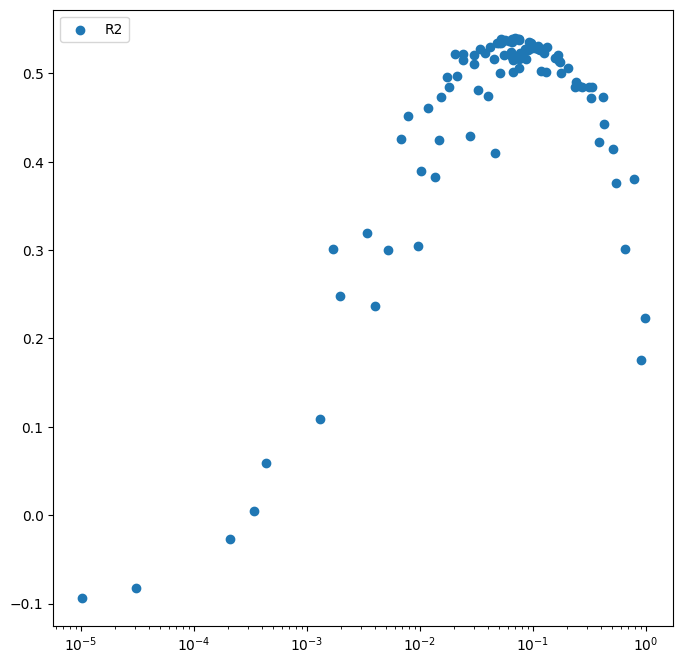

In [19]:
plt.figure(figsize=(8,8))
plt.scatter(df_sort.params_learning_rate.values,df_sort.value.values,label='R2')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

In [20]:
def objective(trial):
    param = {
        'iterations':trial.suggest_int("iterations", 500, 1000, step=100),
        'learning_rate': trial.suggest_float("learning_rate",0.02, 0.1, log=True),
        'depth':trial.suggest_int("depth", 4, 10, step=1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 1.0, log=True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]), 
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]), 
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20), 
        'random_strength':trial.suggest_float("random_strength", 1e-8, 5.0, log=True),
        'leaf_estimation_method':trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
    }
    if param["bootstrap_type"] == "Bayesian": 
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10) 
    elif param["bootstrap_type"] == "Bernoulli": 
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1) 
    
    cat_model = cat.CatBoostRegressor(**param)

    r2 = cross_val_score(cat_model, x, y, n_jobs=-1, cv=5, scoring="r2").mean()
    
    return r2

study = optuna.create_study(
    direction="maximize",
    study_name="catboost_parameter_opt",
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

study.optimize(objective, n_trials=100)
df = study.trials_dataframe()
df.to_csv(r'C:\Users\19189\Desktop\MACCS_cat_trial2.csv',index=False)

[I 2024-04-07 23:53:26,404] A new study created in memory with name: catboost_parameter_opt
[I 2024-04-07 23:54:42,348] Trial 0 finished with value: 0.4831975896760497 and parameters: {'iterations': 600, 'learning_rate': 0.05554215062271757, 'depth': 8, 'l2_leaf_reg': 2.3867558690708396e-06, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'random_strength': 0.0047758814817229454, 'leaf_estimation_method': 'Newton', 'subsample': 0.26056337304160193}. Best is trial 0 with value: 0.4831975896760497.
[I 2024-04-07 23:58:19,612] Trial 1 finished with value: 0.49277497913845136 and parameters: {'iterations': 900, 'learning_rate': 0.03044609840736833, 'depth': 9, 'l2_leaf_reg': 9.00265896342475e-08, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 20, 'random_strength': 9.77399053567599e-07, 'leaf_estimation_method': 'Gradient', 'subsample': 0.38907219646462177}. Best is trial 1 with value: 0.49277497913845136.
[I 2024-04-07 23:

In [6]:
df2=pd.read_csv(r'C:\Users\19189\Desktop\MACCS_cat_trial2.csv')
df2.head(2)

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_depth,params_iterations,params_l2_leaf_reg,params_leaf_estimation_method,params_learning_rate,params_min_data_in_leaf,params_random_strength,params_subsample,state
0,0,0.483198,2024-04-07 23:53:26.405550,2024-04-07 23:54:42.348936,0 days 00:01:15.943386,NaN,Ordered,Bernoulli,8,600,2.386756e-06,Newton,0.055542,14,4.775881e-03,0.260563,COMPLETE
1,1,0.492775,2024-04-07 23:54:42.349952,2024-04-07 23:58:19.610751,0 days 00:03:37.260799,NaN,Ordered,Bernoulli,9,900,9.002659e-08,Gradient,0.030446,20,9.773991e-07,0.389072,COMPLETE


In [9]:
df_sort=df2.sort_values(by='value',ascending=False)
df_sort

,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_depth,params_iterations,params_l2_leaf_reg,params_leaf_estimation_method,params_learning_rate,params_min_data_in_leaf,params_random_strength,params_subsample,state
93,93,0.550829,2024-04-08 01:44:13.324816,2024-04-08 01:45:34.605092,0 days 00:01:21.280276,NaN,Plain,MVS,10,1000,1.352273e-02,Newton,0.031743,3,1.380987e+00,NaN,COMPLETE
83,83,0.548664,2024-04-08 01:31:31.365733,2024-04-08 01:32:54.738655,0 days 00:01:23.372922,NaN,Plain,MVS,10,1000,4.110695e-03,Newton,0.038385,5,4.418820e-01,NaN,COMPLETE
92,92,0.548374,2024-04-08 01:42:51.963879,2024-04-08 01:44:13.324816,0 days 00:01:21.360937,NaN,Plain,MVS,10,1000,3.598355e-02,Newton,0.031805,2,1.079921e+00,NaN,COMPLETE
99,99,0.548163,2024-04-08 01:54:18.970966,2024-04-08 01:55:39.823595,0 days 00:01:20.852629,NaN,Plain,MVS,10,1000,2.353465e-03,Newton,0.030862,2,2.124068e+00,NaN,COMPLETE
87,87,0.548151,2024-04-08 01:35:47.533514,2024-04-08 01:37:14.724087,0 days 00:01:27.190573,NaN,Plain,MVS,10,1000,1.045770e-03,Newton,0.037734,2,4.543202e-01,NaN,COMPLETE
91,91,0.547344,2024-04-08 01:41:30.609249,2024-04-08 01:42:51.962835,0 days 00:01:21.353586,NaN,Plain,MVS,10,1000,1.177540e-03,Newton,0.029697,3,1.097635e+00,NaN,COMPLETE
73,73,0.547083,2024-04-08 01:15:13.360847,2024-04-08 01:16:26.431614,0 days 00:01:13.070767,NaN,Plain,MVS,10,900,9.380084e-04,Newton,0.032544,5,5.667666e-01,NaN,COMPLETE
88,88,0.546857,2024-04-08 01:37:14.725088,2024-04-08 01:38:38.229775,0 days 00:01:23.504687,NaN,Plain,MVS,10,1000,1.921663e-02,Newton,0.028014,3,4.406010e-01,NaN,COMPLETE
96,96,0.546791,2024-04-08 01:48:17.970229,2024-04-08 01:49:38.685741,0 days 00:01:20.715512,NaN,Plain,MVS,10,1000,1.425669e-02,Newton,0.028897,2,3.085423e+00,NaN,COMPLETE
16,16,0.546188,2024-04-08 00:15:22.782974,2024-04-08 00:16:35.717125,0 days 00:01:12.934151,NaN,Plain,MVS,10,900,6.008466e-04,Newton,0.044042,8,6.832130e-02,NaN,COMPLETE


In [8]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [9]:
import optuna
def objective(trial):
    param = {
        'iterations':trial.suggest_int("iterations", 800, 1300, step=100),
        'learning_rate': trial.suggest_float("learning_rate",0.025, 0.04),
        'depth':trial.suggest_int("depth", 6, 14, step=2),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-8, 1.0, log=True),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]), 
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]), 
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20), 
        'random_strength':trial.suggest_float("random_strength", 1e-8, 5.0, log=True),
        'leaf_estimation_method':trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
        'score_function':trial.suggest_categorical("score_function", ["L2", "Cosine"]),
        'early_stopping_rounds':20,
        'od_pval':trial.suggest_float("od_pval", 1e-8, 1e-2, log=True),
    }
    if param["bootstrap_type"] == "Bayesian": 
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10) 
    elif param["bootstrap_type"] == "Bernoulli": 
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1) 
    
    cat_model = cat.CatBoostRegressor(**param)

    r2 = cross_val_score(cat_model, x, y, n_jobs=-1, cv=5, scoring="r2").mean()
    
    return r2

study = optuna.create_study(
    direction="maximize",
    study_name="catboost_parameter_opt",
    pruner = optuna.pruners.MedianPruner(n_warmup_steps=5)
    )

study.optimize(objective, n_trials=1)
df = study.trials_dataframe()
df
#df.to_csv(r'C:\Users\19189\Desktop\MACCS_cat_trial3.csv',index=False)

[I 2024-04-08 13:07:17,349] A new study created in memory with name: catboost_parameter_opt
[I 2024-04-08 13:12:49,411] Trial 0 finished with value: 0.5118836532998705 and parameters: {'iterations': 1300, 'learning_rate': 0.030841939977037304, 'depth': 12, 'l2_leaf_reg': 0.021134589575393135, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 5, 'random_strength': 3.645229541238538e-05, 'leaf_estimation_method': 'Gradient', 'score_function': 'L2', 'od_pval': 2.738443200934092e-05, 'bagging_temperature': 5.808177750724282}. Best is trial 0 with value: 0.5118836532998705.


,number,value,datetime_start,datetime_complete,duration,params_bagging_temperature,params_boosting_type,params_bootstrap_type,params_depth,params_iterations,params_l2_leaf_reg,params_leaf_estimation_method,params_learning_rate,params_min_data_in_leaf,params_od_pval,params_random_strength,params_score_function,state
0,0,0.511884,2024-04-08 13:07:17.349778,2024-04-08 13:12:49.410729,0 days 00:05:32.060951,5.808178,Plain,Bayesian,12,1300,0.021135,Gradient,0.030842,5,0.000027,0.000036,L2,COMPLETE
